In [1]:
from flax import nnx
import jax
import jax.numpy as jnp
import optax
import numpy as np
import orbax.checkpoint as ocp
from typing import List, Optional
import torchvision
from torch.utils.data import DataLoader
from functools import partial
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

In [2]:
class Configs():
    def __init__(self):
        self.batch_size = 64
        self.lr = 1e-3
        self.epochs = 15
        self.warmup_epoch = 2
        self.seed = 42
        self.checkpoint_dir = ''

configs = Configs()

In [3]:
class RadialBasisFunction(nnx.Module):
    def __init__(
            self,
            grid_min: float = -2.0,
            grid_max: float = 2.0,
            num_grids: int = 8,
            denominator : Optional[float] = None,
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        self.grid = nnx.Variable(jnp.linspace(grid_min, grid_max, num_grids))
        self.denominator = denominator if denominator else (grid_max - grid_min) / (num_grids -1)

    def __call__(self, x):
        return jnp.exp(-(((x[..., None] - self.grid) / self.denominator) ** 2))

In [4]:
class FastKANLayer(nnx.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        rngs: nnx.Rngs,
        grid_min: float = -2.0,
        grid_max: float = 2.0,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_update_bias: bool = True,
        use_layernorm: bool = True,
        base_activation=nnx.silu,
        spline_weight_init_scale: float = 0.1,
        denominator: Optional[float] = None,
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.layernorm = None
        if use_layernorm:
            assert (
                input_dim > 1
            ), "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = nnx.LayerNorm(input_dim, epsilon=1e-5, rngs=rngs)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids, denominator)
        coef_key = rngs.coef()
        self.coef = nnx.Param(
            jax.random.truncated_normal(
                coef_key,
                lower=-2.0,
                upper=-2.0,
                shape=(output_dim, input_dim, num_grids),
            )
            * jnp.array(spline_weight_init_scale)
        )
        self.use_base_update = use_base_update
        if self.use_base_update:
            self.base_linear = nnx.Linear(
                input_dim,
                output_dim,
                use_bias=base_update_bias,
                rngs=rngs,
            )
            self.base_activation = base_activation


    def __call__(self, x: jax.Array, use_layernorm: bool = True) -> jax.Array:
        """
        x: B, input_dim, num_grids
        """
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        out = jnp.einsum("bik, oik -> bo", spline_basis, self.coef.value)

        if self.use_base_update:
            res = self.base_linear(self.base_activation(x))
            out = res + out

        return out

In [5]:
class FastKAN(nnx.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        rngs: nnx.Rngs,
        grid_min: float = -2.0,
        grid_max: float = 2.0,
        num_grids: int = 8,
        use_layernorm: bool = True,
        use_base_update: bool = True,
        base_update_bias: bool = True,
        base_activation=nnx.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        self.layers = [
            FastKANLayer(
                input_dim=in_dim,
                output_dim=out_dim,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_layernorm=use_layernorm,
                use_base_update=use_base_update,
                base_update_bias=base_update_bias,
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
                rngs=rngs,
            )
            for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        for layer in self.layers:
            x = layer(x)
        return x

In [6]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def collate_fn(batch):
    images = np.stack([item[0] for item in batch])
    labels = np.stack([item[1] for item in batch])
    images = images.transpose(0, 2, 3, 1)    # nhwc
    return {"image": images, "label": labels}

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = DataLoader(
    trainset,
    batch_size=configs.batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    )

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = DataLoader(
    testset,
    batch_size=configs.batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    )

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
class KANCNN(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        self.conv1 = nnx.Conv(3, 32, kernel_size=(5, 5), rngs=rngs)
        self.pool = partial(nnx.max_pool, window_shape=(2,2), strides=(2,2))
        self.conv2 = nnx.Conv(32, 64, kernel_size=(5, 5), rngs=rngs)
        self.fc1 = FastKAN([8 * 8 * 64, 256], rngs=rngs)
        self.fc2 = FastKAN([256, 10], rngs=rngs)

    def __call__(self, x):
        x = self.pool(nnx.selu(self.conv1(x)))
        x = self.pool(nnx.selu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
    
class MLPCNN(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        self.conv1 = nnx.Conv(3, 32, kernel_size=(5, 5), rngs=rngs)
        self.pool = partial(nnx.max_pool, window_shape=(2,2), strides=(2,2))
        self.conv2 = nnx.Conv(32, 64, kernel_size=(5, 5), rngs=rngs)
        self.fc1 = nnx.Linear(8 * 8 * 64, 256, rngs=rngs)
        self.fc2 = nnx.Linear(256, 10, rngs=rngs)

    def __call__(self, x):
        x = self.pool(nnx.selu(self.conv1(x)))
        x = self.pool(nnx.selu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [8]:
def create_lr_fn(num_epochs: int,
                 warmup_epochs: int,
                 base_lr: float,
                 steps_per_epoch: int,
):
    warmup_fn = optax.linear_schedule(
        init_value=0., end_value=base_lr,
        transition_steps=warmup_epochs * steps_per_epoch,
    )
    consine_epochs = max(num_epochs - warmup_epochs, 1)
    
    cosine_fn = optax.cosine_decay_schedule(
        init_value=base_lr,
        decay_steps=consine_epochs * steps_per_epoch
    )
    schedule_fn = optax.join_schedules(
        schedules=[warmup_fn, cosine_fn],
        boundaries=[warmup_epochs * steps_per_epoch]
    )

    return schedule_fn

steps_per_epoch = len(trainset) // configs.batch_size
schedule_fn = create_lr_fn(
    num_epochs=configs.epochs, warmup_epochs=configs.warmup_epoch,
    base_lr=configs.lr, steps_per_epoch=steps_per_epoch
)

In [ ]:
keys = nnx.Rngs(configs.seed)

model_dict = {
    'kan': KANCNN(rngs=keys),
    'mlp': MLPCNN(rngs=keys),
}

optimizer_dict = {
    'kan': nnx.Optimizer(model_dict['kan'], optax.adamw(learning_rate=schedule_fn)),
    'mlp': nnx.Optimizer(model_dict['mlp'], optax.adamw(learning_rate=schedule_fn)),
}

In [11]:
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average('loss'),
)

In [12]:
def loss_fn(model: nnx.Module, batch):
    logits = model(batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']
    ).mean()
    return loss, logits

@nnx.jit
def train_step(model: nnx.Module, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    model.train()
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch['label'])
    optimizer.update(grads)

@nnx.jit
def eval_step(model: nnx.Module, metrics: nnx.MultiMetric, batch):
    model.eval()
    loss, logits = loss_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch['label'])

In [13]:
ckpt_dir = ocp.test_utils.erase_and_create_empty(configs.checkpoint_dir)
checkpointer = ocp.StandardCheckpointer()

In [14]:
metrics_history = {
    'kan':{
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    },
    'mlp':{
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    },
}


for model_type in ['kan', 'mlp']:
    print(f'{model_type} training start')
    model = model_dict[model_type]
    optimizer = optimizer_dict[model_type]
    min_eval_loss = float('inf')
    start_time = time()

    for epoch in range(configs.epochs):
        for batch in train_loader:

            train_step(model, optimizer, metrics, batch)

        for metric, value in metrics.compute().items():
            metrics_history[model_type][f'train_{metric}'].append(value)
        metrics.reset()

        for test_batch in test_loader:
            eval_step(model, metrics, test_batch)

        for metric, value in metrics.compute().items():
            if metric == 'loss':
                if value < min_eval_loss:
                    min_eval_loss = value
                    state = nnx.state(model)
                    checkpointer.save(ckpt_dir / f'{model_type}_{epoch}ep_state', state)
                    print(f'[{model_type}] epoch {epoch} saved')
            metrics_history[model_type][f'test_{metric}'].append(value)
        metrics.reset()

        print(
            f"epoch: {epoch}, "
            f"train_loss: {metrics_history[model_type]['train_loss'][-1]:.4f}, "
            f"train_accuracy: {metrics_history[model_type]['train_accuracy'][-1] * 100:.4f}, "
            f"test_loss: {metrics_history[model_type]['test_loss'][-1]:.4f}, "
            f"test_accuracy: {metrics_history[model_type]['test_accuracy'][-1] * 100:.4f} "
        )

    end_time = time()
    total_time = end_time - start_time
    print(f'{model_type} elapsed time: {total_time:.2f}sec')

kan training start
[kan] epoch 0 saved
epoch: 0, train_loss: 1.5665, train_accuracy: 43.9600, test_loss: 1.1374, test_accuracy: 58.9600 
[kan] epoch 1 saved
epoch: 1, train_loss: 1.0230, train_accuracy: 63.2640, test_loss: 0.9789, test_accuracy: 65.0800 
[kan] epoch 2 saved
epoch: 2, train_loss: 0.8122, train_accuracy: 71.3180, test_loss: 0.8639, test_accuracy: 69.7100 
[kan] epoch 3 saved
epoch: 3, train_loss: 0.6154, train_accuracy: 78.5240, test_loss: 0.8440, test_accuracy: 70.5600 
[kan] epoch 4 saved
epoch: 4, train_loss: 0.4225, train_accuracy: 85.3300, test_loss: 0.8412, test_accuracy: 72.3800 
epoch: 5, train_loss: 0.2267, train_accuracy: 92.7020, test_loss: 0.8680, test_accuracy: 72.8100 
epoch: 6, train_loss: 0.0763, train_accuracy: 98.1780, test_loss: 0.8812, test_accuracy: 74.2300 
epoch: 7, train_loss: 0.0194, train_accuracy: 99.7860, test_loss: 0.9354, test_accuracy: 75.2700 
epoch: 8, train_loss: 0.0046, train_accuracy: 99.9700, test_loss: 0.9857, test_accuracy: 75.5100 

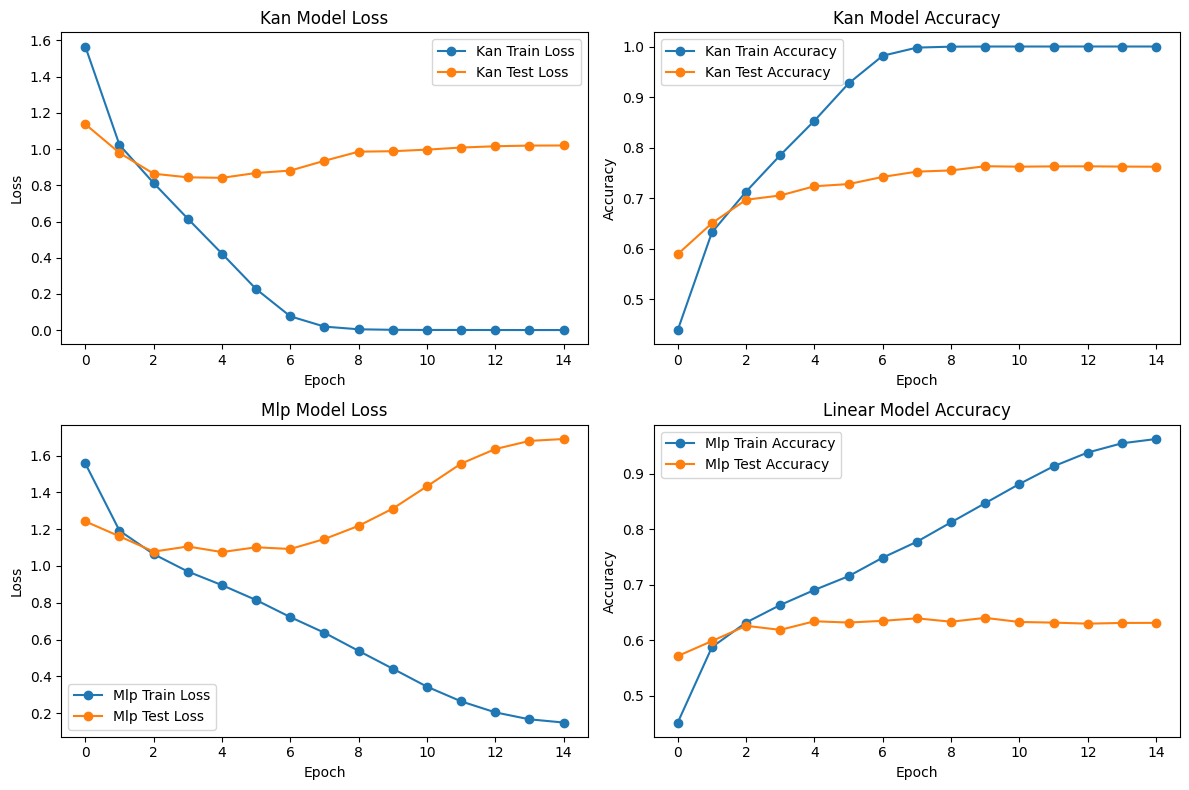

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))


axs[0, 0].plot(metrics_history['kan']['train_loss'], marker='o', label='Kan Train Loss')
axs[0, 0].plot(metrics_history['kan']['test_loss'], marker='o', label='Kan Test Loss')
axs[0, 0].set_title('Kan Model Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

axs[0, 1].plot(metrics_history['kan']['train_accuracy'], marker='o', label='Kan Train Accuracy')
axs[0, 1].plot(metrics_history['kan']['test_accuracy'], marker='o', label='Kan Test Accuracy')
axs[0, 1].set_title('Kan Model Accuracy')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

axs[1, 0].plot(metrics_history['mlp']['train_loss'], marker='o', label='Mlp Train Loss')
axs[1, 0].plot(metrics_history['mlp']['test_loss'], marker='o', label='Mlp Test Loss')
axs[1, 0].set_title('Mlp Model Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

axs[1, 1].plot(metrics_history['mlp']['train_accuracy'], marker='o', label='Mlp Train Accuracy')
axs[1, 1].plot(metrics_history['mlp']['test_accuracy'], marker='o', label='Mlp Test Accuracy')
axs[1, 1].set_title('Linear Model Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [17]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

abstract_model = model_dict['kan']
graphdef, abstract_state = nnx.split(abstract_model)
state_restored = checkpointer.restore(ckpt_dir / 'kan_4ep_state', abstract_state)
model = nnx.merge(graphdef, state_restored)

for batch in test_loader:
    logits = model(batch['image'])
    predictions = np.argmax(logits, 1)

    for label, prediction in zip(batch['label'], predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for [kan] class {classname:5s} : {accuracy:.1f} %')

Accuracy for [kan] class plane : 84.8 %
Accuracy for [kan] class car   : 76.8 %
Accuracy for [kan] class bird  : 50.5 %
Accuracy for [kan] class cat   : 54.2 %
Accuracy for [kan] class deer  : 73.5 %
Accuracy for [kan] class dog   : 61.2 %
Accuracy for [kan] class frog  : 80.0 %
Accuracy for [kan] class horse : 84.1 %
Accuracy for [kan] class ship  : 82.1 %
Accuracy for [kan] class truck : 76.5 %


In [18]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

abstract_model = model_dict['mlp']
graphdef, abstract_state = nnx.split(abstract_model)
state_restored = checkpointer.restore(ckpt_dir / 'mlp_4ep_state', abstract_state)
model = nnx.merge(graphdef, state_restored)

for batch in test_loader:
    logits = model(batch['image'])
    predictions = np.argmax(logits, 1)

    for label, prediction in zip(batch['label'], predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for [mlp] class {classname:5s} : {accuracy:.1f} %')

Accuracy for [mlp] class plane : 63.8 %
Accuracy for [mlp] class car   : 77.8 %
Accuracy for [mlp] class bird  : 40.3 %
Accuracy for [mlp] class cat   : 50.7 %
Accuracy for [mlp] class deer  : 51.9 %
Accuracy for [mlp] class dog   : 53.1 %
Accuracy for [mlp] class frog  : 80.6 %
Accuracy for [mlp] class horse : 65.1 %
Accuracy for [mlp] class ship  : 80.7 %
Accuracy for [mlp] class truck : 69.8 %
